In [1]:
# Ribosome binding site analysis

In [ ]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
import seaborn as sns 
import glob
from matplotlib.gridspec import GridSpec
from src.files import FASTAFile, InterProScanFile
from tqdm import tqdm
from src.reference import annotate
import src.reference as reference
from scipy.stats import chisquare, chi2_contingency, mannwhitneyu
from scipy.stats.contingency import expected_freq
import re
from src.files import BLASTJsonFile

%load_ext autoreload 
%autoreload 2

get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# This could suggest that the lack of RBS in the conflicting sequences is a result of selection bias: if PGAP is comparatively stringent in its RBS requirements, then
# the Prodigal-predicted sequences which don’t have matches in the reference are more likely to lack an RBS; this hypothesis is supported by the observation that no intergenic
# ORFs have an RBS. If selection bias is the root cause of the lack of RBS, then these results would suggest that the presence of RBS is not strongly correlated with coding 
# potential of the sequence. Indeed, it seems as though sequences with an identified RBS are more likely to be classified as spurious. If the model predictions are correct,
# this could indicate that one cause of erroneous ORF identification is RBS overprediction. 

In [721]:
def get_chi_square_p_value(observed_counts_df:pd.DataFrame):
    # totals = observed_counts_df.sum(axis=1)
    # Not sure if I should be testing for independence, or using the null that they are equally-distributed. 
    # expected_counts_df = pd.DataFrame(0.5, index=observed_counts_df.index, columns=observed_counts_df.columns)
    # expected_counts_df = expected_counts_df.mul(totals, axis=0)
    expected_counts_df = pd.DataFrame(expected_freq(observed_counts_df), index=observed_counts_df.index, columns=observed_counts_df.columns) # This uses frequencies based on the marginal frequencies.
    p = chisquare(observed_counts_df.values.ravel(), expected_counts_df.values.ravel()).pvalue
    return p

In [756]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
# Some of these are null instead of NaN because of the capitalized Nones.
# dataset_df['query_rbs_motif'] = np.where(dataset_df.query_rbs_motif.isnull(), 'none', dataset_df.query_rbs_motif)
all_hits_df = pd.read_csv('../data/results/results-2/all_hits.csv', index_col=0)

dataset_df = annotate(dataset_df)
dataset_df['top_hit_hypothetical'] = dataset_df.top_hit_product == 'hypothetical protein'
# Make sure these are in units of amino acids. 
dataset_df['query_length'] = dataset_df.seq.apply(len)
dataset_df['top_hit_length'] = dataset_df.top_hit_seq.apply(len)
all_hits_df = annotate(all_hits_df, prefix='subject')

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

interpro_df = pd.concat([InterProScanFile(path).to_df() for path in glob.glob('../data/interpro/*')])
ids_with_antifam_hit = interpro_df[interpro_df.interpro_analysis == 'AntiFam'].index.unique()
ids_with_antifam_hit = np.intersect1d(ids_with_antifam_hit, dataset_df.index) # Make sure to remove AntiFam hits from the excluded genomes.
dataset_df['antifam_hit'] = dataset_df.index.isin(ids_with_antifam_hit)

antifam_interpro_df = interpro_df.loc[ids_with_antifam_hit].sort_values('interpro_e_value')
antifam_interpro_df = antifam_interpro_df[~antifam_interpro_df.index.duplicated(keep='first')].copy()

print('Num. proteins with AntiFam hit:', len(ids_with_antifam_hit))
for description, df in antifam_interpro_df.groupby('interpro_signature_description'):
    description = description[0].lower() + description[1:]
    print(f'\tNum. {description}:', len(df))


Num. proteins with AntiFam hit: 27
	Num. antisense to 23S rRNA: 5
	Num. antisense to RNaseP: 2
	Num. translation of CRISPR region: 9
	Num. tRNA translation: 11


In [757]:
is_cds_conflict = lambda df : (df.conflict) & (df.top_hit_feature == 'CDS') & (~df.top_hit_pseudo)
is_antiparallel_cds_conflict = lambda df : is_cds_conflict(df) & (df.overlap_type.isin(['convergent', 'divergent']))
is_hypothetical_cds_conflict = lambda df : df.conflict & (df.top_hit_product == 'hypothetical protein')
is_supported_cds_conflict = lambda df : is_cds_conflict(df) & (~df.top_hit_hypothetical)
is_unsupported_cds_conflict = lambda df : is_cds_conflict(df) & (df.top_hit_hypothetical)
is_non_coding_conflict = lambda df : df.conflict & (df.top_hit_feature != 'CDS')

def is_top_hit_match(row, exact:bool=False):
    mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id)
    mask = mask & dataset_df.exact_match if exact else dataset_df.match
    mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
    # assert mask.sum() <= 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
    return mask.sum() > 0

def is_top_hit_match_in_conflict(row):
    if not row.conflict:
        return False
    mask = (dataset_df.top_hit_contig_id == row.top_hit_contig_id) & dataset_df.match
    mask = mask & (dataset_df.top_hit_locus_tag == row.top_hit_locus_tag)
    if mask.sum() < 1: # Then there is no match. 
        return False 
    assert mask.sum() == 1, f'top_hit_has_match: Expected there to be at most one match, but found {mask.sum()}.'
    top_hit_match = dataset_df[mask].iloc[0]
    return not ((row.query_stop < top_hit_match.query_start) or (row.query_start > top_hit_match.query_stop))
    
# dataset_df['top_hit_match'] = dataset_df.apply(is_top_hit_match, axis=1)
# dataset_df['top_hit_exact_match'] = dataset_df.apply(lambda row : is_top_hit_match(row, exact=True), axis=1)
dataset_df['top_hit_match_in_conflict'] = dataset_df.apply(is_top_hit_match_in_conflict, axis=1)

In [823]:
threshold = 0.8

results_df = pd.read_csv('../data/results/results-2/dataset_predict.csv', index_col=0)
results_df.columns = [col.replace('_v2', '') for col in results_df.columns]
results_df = results_df.merge(dataset_df, left_index=True, right_index=True, how='inner')
results_df['spurious'] = np.where(results_df.model_output_0 > threshold, True, False)
results_df['real'] = np.where(results_df.model_output_1 > threshold, True, False)
results_df['uncertain'] = ~results_df.real & ~results_df.spurious
results_df['model_label'] = np.select([results_df.real, results_df.spurious.values, results_df.uncertain.values], ['real', 'spurious', 'uncertain'], default='none')

top_hit_results_df = pd.read_csv('../data/results/results-2/top_hits_predict.csv', index_col=0)
top_hit_results_df.columns = [col.replace('_v2', '') for col in top_hit_results_df.columns]
top_hit_results_df = top_hit_results_df[~top_hit_results_df.index.duplicated(keep='first')].copy()

with pd.option_context('future.no_silent_downcasting', True):
    results_df['top_hit_real'] = results_df.top_hit_protein_id.map(top_hit_results_df.model_output_1 > threshold).fillna(False).astype(bool)
    results_df['top_hit_spurious'] = results_df.top_hit_protein_id.map(top_hit_results_df.model_output_0 > threshold).fillna(False).astype(bool)
    results_df['top_hit_uncertain'] = results_df.top_hit_protein_id.map((top_hit_results_df.model_output_0 <= threshold) & (top_hit_results_df.model_output_1 <= threshold)).fillna(False).astype(bool)
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_real, 'real', 'none')
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_spurious, 'spurious', results_df.top_hit_model_label)
    results_df['top_hit_model_label'] = np.where(results_df.top_hit_uncertain, 'uncertain', results_df.top_hit_model_label)

0. Thermophilibacter immobilis 86.89%
1. Clostridium sardiniense 79.93%
2. Atribacter laminatus 78.48%
0. Fodinibius halophilus 10.95%
1. Abditibacterium utsteinense 27.44%
2. Limnoraphis robusta 32.60%


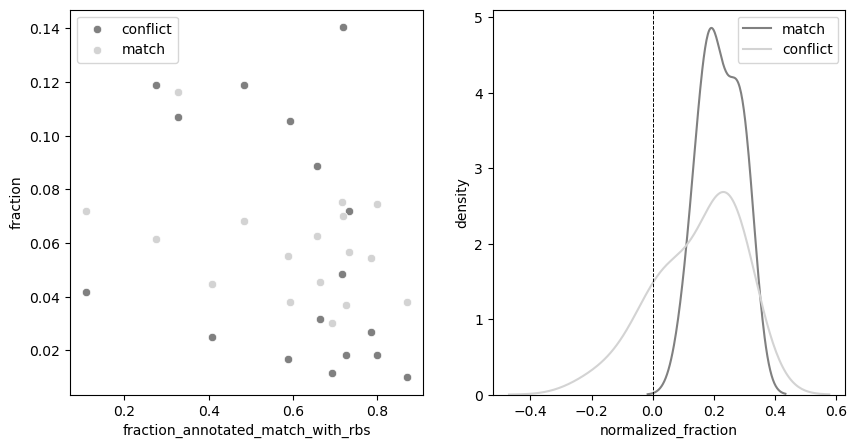

table: Removing 316 sequences that are partial at the N-terminus.


model_label,real,spurious,uncertain,p_value
category,,,,
conflict,66.17% (n=133),67.24% (n=406),40.0% (n=35),0.996856
intergenic,0.0% (n=255),0.0% (n=336),0.0% (n=63),1.000000
match,70.26% (n=48587),66.06% (n=330),66.41% (n=259),0.429437
pseudogene,55.89% (n=467),50.0% (n=14),55.56% (n=9),0.979024


In [ ]:
# Preliminary analysis of the detected ribosome binding site (RBS) motifs upstream of the conflicting sequences shows that a significantly lower fraction (p > ) of all conflicting sequences are 
# associated with a ribosome binding motif as compared with the matched sequences [SI TABLE]. However, this effect seems to be due primarily to the fact that species with larger leaderless 
# gene fractions contribute disproportionately to the set of conflicts; indeed, when the fraction of conflicts with an RBS is normalized according to the leadered peptide content of the corresponding 
# genome, we observe that conflicts are somewhat more likely to have an associated RBS relative to annotated genes. This result suggests that a potential cause of Prodigal false positives is RBS 
# overprediction. Due to the apparent variability of translation initiation mechanisms evidently used within the selected genomes, it is difficult to determine the extent to which RBS sites serve 
# as a reliable signal for gene validity when considering the aggregated dataset; we therefore opted to use more highly-conserved signals to assess the validity of model predictions. 

def table(results_df:pd.DataFrame):
    is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
    partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
    print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
    results_df = results_df[~partial_at_n_terminus_mask].copy()

    results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
    results_df['rbs_motif'] =  results_df.rbs_motif != 'none' 
    
    p_values = dict()
    for category, df in results_df[results_df.real | results_df.spurious].groupby('category'):
        p_values[category] = get_chi_square_p_value(pd.crosstab(df.model_label, df.rbs_motif))

    totals_df = pd.crosstab(results_df['category'], results_df['model_label'])
    results_df = results_df[results_df.rbs_motif].copy()
    table_df = pd.crosstab(results_df['category'], results_df['model_label'])

    table_df = np.round(100 * table_df / totals_df, 2)
    table_df = table_df.fillna(0)
    table_df = table_df.astype(str)

    for model_label in table_df.columns:
        for category in table_df.index:
            p = table_df.loc[category, model_label]
            table_df.loc[category, model_label] = f'{p}% (n={totals_df.loc[category, model_label]})'

    table_df['p_value'] = table_df.index.map(p_values)

    return table_df

def figure(results_df:pd.DataFrame):
    
    is_annotated_match = lambda df : df.match & (df.top_hit_product != 'hypothetical protein')
    # is_annotated_match = lambda df : df.match & ~((df.top_hit_product == 'hypothetical protein') & (df.top_hit_evidence_type != 'ab initio prediction'))

    figure_df = results_df.copy()
    figure_df['rbs_motif'] = ~(figure_df.query_rbs_motif.str.contains('T') | (figure_df.query_rbs_motif == 'none')) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
    figure_df['annotated_match'] = is_annotated_match(figure_df)

    ax_df = pd.DataFrame(index=pd.Series(results_df.species.unique(), name='species'))
    ax_df['fraction_conflict'] = figure_df.groupby('species').apply(lambda df : df.conflict.sum() / figure_df.conflict.sum(), include_groups=False)
    ax_df['fraction_match'] = figure_df.groupby('species').apply(lambda df :df.match.sum() / figure_df.match.sum(), include_groups=False)
    ax_df['fraction_spurious'] = figure_df.groupby('species').apply(lambda df : df.spurious.sum() / figure_df.spurious.sum(), include_groups=False)
    ax_df['fraction_real'] = figure_df.groupby('species').apply(lambda df :df.real.sum() / figure_df.real.sum(), include_groups=False)
    ax_df['fraction_annotated_match_with_rbs'] = figure_df.groupby('species').apply(lambda df :(df.rbs_motif & df.annotated_match).sum() / len(df), include_groups=False)

    ax_df['n_conflict'] = figure_df.groupby('species').apply(lambda df : df.conflict.sum(), include_groups=False)
    ax_df['n_match'] = figure_df.groupby('species').apply(lambda df : df.match.sum(), include_groups=False)
    # ax_df['n_spurious'] = figure_df.groupby('species').apply(lambda df : df.conflict.sum(), include_groups=False)
    # ax_df['n_real'] = figure_df.groupby('species').apply(lambda df : df.match.sum(), include_groups=False)


    ax_df['fraction_match_with_rbs'] = figure_df.groupby('species').apply(lambda df :(df.rbs_motif & df.match).sum() / df.match.sum(), include_groups=False)
    ax_df['fraction_conflict_with_rbs'] = figure_df.groupby('species').apply(lambda df :(df.rbs_motif  & df.conflict).sum() / df.conflict.sum(), include_groups=False)

    ax_df['fraction_conflict_with_rbs_normalized'] = np.log(ax_df.fraction_conflict_with_rbs / ax_df.fraction_annotated_match_with_rbs)
    ax_df['fraction_match_with_rbs_normalized'] = np.log(ax_df.fraction_match_with_rbs / ax_df.fraction_annotated_match_with_rbs)

    for i, row in enumerate(ax_df.sort_values('fraction_annotated_match_with_rbs', ascending=False).iloc[:3].itertuples()):
        print(f'{i}. {row.Index} {row.fraction_annotated_match_with_rbs * 100:.2f}%')
    for i, row in enumerate(ax_df.sort_values('fraction_annotated_match_with_rbs', ascending=True).iloc[:3].itertuples()):
        print(f'{i}. {row.Index} {row.fraction_annotated_match_with_rbs * 100:.2f}%')

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    sns.scatterplot(ax_df, x='fraction_annotated_match_with_rbs', y='fraction_conflict', ax=ax_a, color='gray', label='conflict')
    sns.scatterplot(ax_df, x='fraction_annotated_match_with_rbs', y='fraction_match', ax=ax_a, color='lightgray', label='match')
    # sns.scatterplot(ax_df, x='fraction_annotated_match_with_rbs', y='fraction_spurious', ax=ax_a, color='indianred', label='spurious')
    # sns.scatterplot(ax_df, x='fraction_annotated_match_with_rbs', y='fraction_real', ax=ax_a, color='darkseagreen', label='real')
    ax_a.set_ylabel('fraction')

    sns.kdeplot(ax=ax_b, data=ax_df, x='fraction_match_with_rbs_normalized', color='gray', common_norm=False, weights='n_match', label='match')
    sns.kdeplot(ax=ax_b, data=ax_df, x='fraction_conflict_with_rbs_normalized', color='lightgray', common_norm=False, weights='n_conflict', label='conflict')
    ax_b.legend()
    ax_b.axvline(x=0, ls='--', color='black', lw=0.7)
    ax_b.set_ylabel('density')
    ax_b.set_xlabel('normalized_fraction')
    plt.show()

figure(results_df)
table(results_df)

In [995]:
# species_results_df = results_df[results_df.species == 'Fodinibius halophilus'].copy() 
species_results_df = results_df[results_df.species == 'Thermophilibacter immobilis'].copy()
species_results_df['rbs_motif'] = ~(species_results_df.query_rbs_motif.str.contains('T') | (species_results_df.query_rbs_motif == 'none')) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
totals_df = pd.crosstab(species_results_df.rbs_motif, species_results_df.model_label)
table_df = pd.crosstab(species_results_df.rbs_motif, species_results_df.model_label) / totals_df.sum(axis=0)
table_df = np.round(100 * table_df, 1).astype(str)
for model_label in table_df.columns:
    for category in table_df.index:
        p = table_df.loc[category, model_label]
        table_df.loc[category, model_label] = f'{p}% (n={totals_df.loc[category, model_label]})'
table_df

model_label,real,spurious,uncertain
rbs_motif,,,
False,4.5% (n=85),31.6% (n=6),8.3% (n=1)
True,95.5% (n=1791),68.4% (n=13),91.7% (n=11)


In [996]:
species_results_df = results_df[results_df.species == 'Fodinibius halophilus'].copy() 
# species_results_df = results_df[results_df.species == 'Thermophilibacter immobilis'].copy()
species_results_df['rbs_motif'] = ~(species_results_df.query_rbs_motif.str.contains('T') | (species_results_df.query_rbs_motif == 'none')) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
totals_df = pd.crosstab(species_results_df.rbs_motif, species_results_df.model_label)
table_df = pd.crosstab(species_results_df.rbs_motif, species_results_df.model_label) / totals_df.sum(axis=0)
table_df = np.round(100 * table_df, 1).astype(str)
for model_label in table_df.columns:
    for category in table_df.index:
        p = table_df.loc[category, model_label]
        table_df.loc[category, model_label] = f'{p}% (n={totals_df.loc[category, model_label]})'
table_df

model_label,real,spurious,uncertain
rbs_motif,,,
False,85.7% (n=3067),94.4% (n=85),93.3% (n=28)
True,14.3% (n=511),5.6% (n=5),6.7% (n=2)


In [333]:
total_conflict = dataset_df.conflict.sum()
n_unsupported_conflict = (dataset_df.conflict & dataset_df.top_hit_unsupported).sum()
n_hypothetical_conflict = (dataset_df.conflict & dataset_df.top_hit_hypothetical).sum()
print('Num. unsupported conflicts:', n_unsupported_conflict, f'({get_percent(n_unsupported_conflict, total_conflict)})')
print('Num. conflicts with hypothetical proteins:', n_hypothetical_conflict, f'({get_percent(n_hypothetical_conflict, total_conflict)})')

Num. unsupported conflicts: 134 (22.41%)
Num. conflicts with hypothetical proteins: 153 (25.59%)


In [ ]:
# def table(results_df:pd.DataFrame):
#     results_df = results_df[results_df.match].copy()
#     results_df['hypothetical'] = (results_df.top_hit_product == 'hypothetical protein') & ~(results_df.top_hit_evidence_type != 'ab initio prediction')
#     results_df['annotated'] = (results_df.top_hit_product != 'hypothetical protein')
#     results_df['ab_initio'] = ((results_df.top_hit_product == 'hypothetical protein') & (results_df.top_hit_evidence_type != 'ab initio prediction'))
#     results_df['category'] = np.select([results_df.hypothetical, results_df.ab_initio, results_df.annotated], ['hypothetical', 'ab_initio', 'annotated'], default='none')

#     is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
#     partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
#     print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
#     results_df = results_df[~partial_at_n_terminus_mask].copy()

#     results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/
#     results_df['rbs_motif'] =  results_df.rbs_motif != 'none' 

#     p_values = dict()
#     for category, df in results_df[results_df.real | results_df.spurious].groupby('category'):
#         p_values[category] = get_chi_square_p_value(pd.crosstab(df.model_label, df.rbs_motif))

#     totals_df = pd.crosstab(results_df['category'], results_df['model_label'])
#     results_df = results_df[results_df.rbs_motif].copy()
#     table_df = pd.crosstab(results_df['category'], results_df['model_label'])

#     table_df = np.round(100 * table_df / totals_df, 2)
#     table_df = table_df.fillna(0)
#     table_df = table_df.astype(str)

#     for model_label in table_df.columns:
#         for category in table_df.index:
#             p = table_df.loc[category, model_label]
#             table_df.loc[category, model_label] = f'{p}% (n={totals_df.loc[category, model_label]})'

#     table_df['p_value'] = table_df.index.map(p_values)

#     return table_df

# table(results_df)

# # Anything more than ab initio prediction implies that the sequence is at least somewhat conserved, either (1) identified in at least one other reference genome
# # and assigned a WP* protein ID, or (2) identified by a "domain of unknown function" motif. This means that, if the sequence is indeed spurious, it is more likely
# # to be a consistent false positive gene, implying something like a translated regulatory element or RNA gene. This could explain why these sequences are more
# # likely to be spurious if lacking an RBS. 

In [970]:
# # It is worth noting that a large fraction of conflicts with non-coding elements have RBS.

# def table(results_df:pd.DataFrame, normalize:bool=False):

#     # results_df = results_df[is_non_coding_conflict(results_df)].copy()
#     results_df = results_df[is_cds_conflict(results_df)].copy()

#     is_partial_at_n_terminus = lambda row : ((row.query_partial == '10') and (row.query_strand == 1)) or (row.query_partial == '01') and (row.query_strand == -1)
#     is_tandem_conflict_with_query_downstream = lambda row : (((row.query_overlap == '10') & (row.query_strand == 1)) | ((row.query_overlap == '10') & (row.query_strand == -1))) and (row.overlap_length in [1, 4]) and (row.overlap_type == 'tandem') and (row.conflict)

#     partial_at_n_terminus_mask = results_df.apply(is_partial_at_n_terminus, axis=1)
#     print(f'table: Removing {partial_at_n_terminus_mask.sum()} sequences that are partial at the N-terminus.')
#     results_df = results_df[~partial_at_n_terminus_mask].copy()

#     tandem_conflict_with_query_downstream_mask = results_df.apply(is_tandem_conflict_with_query_downstream, axis=1)
#     print(f'table: Removing {tandem_conflict_with_query_downstream_mask.sum()} sequences that tandem overlaps of 1 or 4 base pairs with the query downstream.')
#     results_df = results_df[~tandem_conflict_with_query_downstream_mask].copy()
    
#     results_df['rbs_motif'] = np.where(results_df.query_rbs_motif.str.contains('T'), 'none', results_df.query_rbs_motif) # Consider the non-standard RBS motifs as "none," as per https://pmc.ncbi.nlm.nih.gov/articles/PMC4535381/

    
#     totals_df = pd.crosstab(results_df['overlap_type'], results_df['model_label'])

#     results_df = results_df[results_df.rbs_motif != 'none']
#     table_df = pd.crosstab(results_df['overlap_type'], results_df['model_label'])

#     if normalize:
#         table_df = np.round(100 * table_df / totals_df, 2)

#     table_df = table_df.astype(str)

#     for model_label in table_df.columns:
#         for overlap_type in table_df.index:
#             p = table_df.loc[overlap_type, model_label]
#             table_df.loc[overlap_type, model_label] = f'{p}% ({totals_df.loc[overlap_type, model_label]})'

#     return table_df

# table(results_df, normalize=True)